In [1]:
import numpy as np
import matplotlib.pyplot as plt


In [2]:
np.random.seed(0)
def gen_data(n_samples=1000):
    A = []
    B = []
    ctr = [[0, 3], [3, 0], [0, -3], [-3, 0], [5, 2]]
    per = n_samples // len(ctr)

    for i, c in enumerate(ctr):
        a = np.random.randn(per, 2) * 0.5 + c
        b = np.full((per,), i)
        A.append(a)
        B.append(b)

    A = np.vstack(A)
    B = np.hstack(B)

    idx = np.random.permutation(len(A))
    return A[idx], B[idx]


In [3]:
def onehot(b, num_classes=5):
    oh = np.zeros((b.size, num_classes))
    oh[np.arange(b.size), b] = 1
    return oh

def split_train_test(A, B, test_ratio=0.2):
    idx = np.arange(len(A))
    np.random.shuffle(idx)
    split = int(len(A) * (1 - test_ratio))
    return A[:split], A[split:], B[:split], B[split:]

def softmax(z):
    z = z - np.max(z, axis=1, keepdims=True)
    e = np.exp(z)
    return e / np.sum(e, axis=1, keepdims=True)

def cross_entropy(probs, y_onehot):
    eps = 1e-12
    return -np.mean(np.sum(y_onehot * np.log(probs + eps), axis=1))


In [4]:
class NeuralNet:
    def __init__(self, lr=0.01):
        input_layer = 2
        n1 = 50
        n2 = 25
        n3 = 15
        out_layer = 5
        self.lr = lr

        # initialization of HE
        self.W1 = np.random.randn(input_layer, n1) * np.sqrt(2 / input_layer)
        self.b1 = np.zeros((1, n1))
        self.W2 = np.random.randn(n1, n2) * np.sqrt(2 / n1)
        self.b2 = np.zeros((1, n2))
        self.W3 = np.random.randn(n2, n3) * np.sqrt(2 / n2)
        self.b3 = np.zeros((1, n3))
        self.W4 = np.random.randn(n3, out_layer) * np.sqrt(2 / n3)
        self.b4 = np.zeros((1, out_layer))

    # For better performance ReLU is choosen
    def relu(self, a):
        return np.maximum(0, a)

    def relu_deriv(self, z):
        return (z > 0).astype(float)

    def forward(self, A):
        self.A = A
        self.z1 = A.dot(self.W1) + self.b1
        self.a1 = self.relu(self.z1)
        self.z2 = self.a1.dot(self.W2) + self.b2
        self.a2 = self.relu(self.z2)
        self.z3 = self.a2.dot(self.W3) + self.b3
        self.a3 = self.relu(self.z3)
        self.z4 = self.a3.dot(self.W4) + self.b4
        self.pred = softmax(self.z4)
        return self.pred

    def backward(self, B):
        m = B.shape[0]
        dz4 = (self.pred - B) / m
        dW4 = self.a3.T.dot(dz4)
        db4 = np.sum(dz4, axis=0, keepdims=True)
        da3 = dz4.dot(self.W4.T)
        dz3 = da3 * self.relu_deriv(self.z3)
        dW3 = self.a2.T.dot(dz3)
        db3 = np.sum(dz3, axis=0, keepdims=True)
        da2 = dz3.dot(self.W3.T)
        dz2 = da2 * self.relu_deriv(self.z2)
        dW2 = self.a1.T.dot(dz2)
        db2 = np.sum(dz2, axis=0, keepdims=True)
        da1 = dz2.dot(self.W2.T)
        dz1 = da1 * self.relu_deriv(self.z1)
        dW1 = self.A.T.dot(dz1)
        db1 = np.sum(dz1, axis=0, keepdims=True)

        self.W4 -= self.lr * dW4
        self.b4 -= self.lr * db4
        self.W3 -= self.lr * dW3
        self.b3 -= self.lr * db3
        self.W2 -= self.lr * dW2
        self.b2 -= self.lr * db2
        self.W1 -= self.lr * dW1
        self.b1 -= self.lr * db1

    def train(self, A, B):
        pred = self.forward(A)
        loss = cross_entropy(pred, B)
        self.backward(B)
        return loss

    def predict(self, A):
        return np.argmax(self.forward(A), axis=1)


## Modification Made to the Code
- Added one more hidden layer.  
- Used ReLU activation in hidden layers.  
- Added softmax in the output layer.  
- Used He initialization for all weights.  
- Implemented manual forward pass.  
- Implemented manual backward pass.  
- Added loss tracking and accuracy checks.


In [5]:
A, B = gen_data(1000)
A_train, A_test, b_train, b_test = split_train_test(A, B, 0.2)

mean = A_train.mean(axis=0, keepdims=True)
std = A_train.std(axis=0, keepdims=True) + 1e-8
A_train = (A_train - mean) / std
A_test = (A_test - mean) / std

b_train_oh = onehot(b_train)
b_test_oh = onehot(b_test)


Epoch 0 | Loss=2.048 | Train Accuracy=0.176 | Test Accuracy=0.235
Epoch 400 | Loss=0.061 | Train Accuracy=0.991 | Test Accuracy=0.985
Epoch 800 | Loss=0.033 | Train Accuracy=0.995 | Test Accuracy=0.985
Epoch 1200 | Loss=0.024 | Train Accuracy=0.995 | Test Accuracy=0.990
Epoch 1600 | Loss=0.020 | Train Accuracy=0.995 | Test Accuracy=0.990
Epoch 2000 | Loss=0.017 | Train Accuracy=0.996 | Test Accuracy=0.990
Epoch 2400 | Loss=0.015 | Train Accuracy=0.996 | Test Accuracy=0.995
Epoch 2800 | Loss=0.013 | Train Accuracy=0.996 | Test Accuracy=0.995
Epoch 3200 | Loss=0.012 | Train Accuracy=0.996 | Test Accuracy=0.995


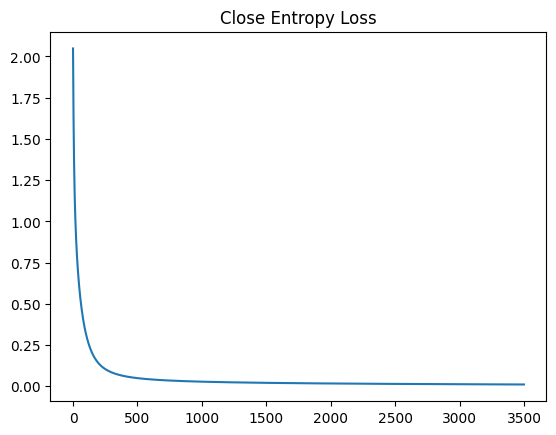

In [6]:
net = NeuralNet(lr=0.01)

losses = []
epochs = 3500

for i in range(epochs):
    loss = net.train(A_train, b_train_oh)
    losses.append(loss)

    if i % 400 == 0:
        train_acc = np.mean(net.predict(A_train) == b_train)
        test_acc  = np.mean(net.predict(A_test) == b_test)
        print(f"Epoch {i} | Loss={loss:.3f} | Train Accuracy={train_acc:.3f} | Test Accuracy={test_acc:.3f}")

plt.plot(losses)
plt.title("Close Entropy Loss")
plt.show()


In [7]:
def conf_matrix(y_true, y_pred, num_classes=5):
    cm = np.zeros((num_classes, num_classes), dtype=int)
    for t, p in zip(y_true, y_pred):
        cm[t][p] += 1
    return cm

def class_report(cm):
    precision = []
    recall = []
    f1 = []
    for c in range(len(cm)):
        TP = cm[c][c]
        FP = cm[:,c].sum() - TP
        FN = cm[c].sum() - TP

        p = TP / (TP + FP) if (TP + FP) else 0
        r = TP / (TP + FN) if (TP + FN) else 0
        f = (2*p*r)/(p+r) if (p+r) else 0

        precision.append(p)
        recall.append(r)
        f1.append(f)
    return precision, recall, f1

y_pred = net.predict(A_test)
cm = conf_matrix(b_test, y_pred)

print("\nConfusion Matrix:\n", cm)

precision, recall, f1 = class_report(cm)
for i in range(5):
    print(f"Class {i}: Precision={precision[i]:.3f}, Recall={recall[i]:.3f}, F1={f1[i]:.3f}")

print("\nOverall Accuracy:", np.mean(y_pred == b_test))



Confusion Matrix:
 [[32  0  0  0  0]
 [ 0 36  0  0  1]
 [ 0  0 50  0  0]
 [ 0  0  0 49  0]
 [ 0  0  0  0 32]]
Class 0: Precision=1.000, Recall=1.000, F1=1.000
Class 1: Precision=1.000, Recall=0.973, F1=0.986
Class 2: Precision=1.000, Recall=1.000, F1=1.000
Class 3: Precision=1.000, Recall=1.000, F1=1.000
Class 4: Precision=0.970, Recall=1.000, F1=0.985

Overall Accuracy: 0.995


## Result and Analysis
- Loss decreased smoothly during training.  
- Training accuracy increased over time.  
- Most classes were predicted correctly.  
- Only a few samples were misclassified.  
- Training was stable and consistent.


## Conclusion
- The network worked well for multi-class classification.  
- Extra layers improved learning ability.  
- Manual coding helped understand neural networks better.  
- Final accuracy showed strong performance.


## Main Findings
- More layers help the model learn complex patterns.  
- ReLU and He initialization improve training.  
- Softmax is effective for multi-class output.  
- Manual backpropagation builds clear intuition.


## Challenges and Lessons Learned
- Debugging gradient and shape mismatch errors required careful attention.  
- Choosing an appropriate learning rate was crucial for stable convergence.  
- Proper weight initialization had a major impact on early training behavior.  
- The model can overfit with deeper layers, highlighting the need for regularization.


## Future Improvements
- Add regularization methods such as dropout, L2, or early stopping.  
- Implement mini-batch gradient descent for faster and more efficient training.  
- Experiment with adaptive optimizers like Adam or RMSProp.  
- Add visualizations such as decision boundary plots.  
- Test the model on larger or real-world datasets for stronger validation.
